In [12]:
from pathlib import Path
from typing import Dict, List, Any

import sys
import importlib

import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from alibi.explainers import ALE, plot_ale
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import TheilSenRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

try:
    NOTEBOOK_DIR = Path(__file__).resolve().parent
except NameError:
    NOTEBOOK_DIR = Path.cwd().resolve()
SRC_ROOT = NOTEBOOK_DIR.parent
PROJECT_ROOT = SRC_ROOT.parent
if str(SRC_ROOT) not in sys.path:
    sys.path.insert(0, str(SRC_ROOT))

# Import specific model implementations and reload to ensure latest changes are used
import classification.xgboost_model
importlib.reload(classification.xgboost_model)
from classification.xgboost_model import XGBoostThresholdClassifier, FlightDataPreprocessor
from classification.load_data import FEATURES as CLF_FEATURES
from regression.load_data import FEATURES as REG_FEATURES

# Placeholders
xgb_exp = None
xgb_readable_feature_names: List[str] = []
ts_exp = None
ts_readable_feature_names: List[str] = []
category_map = {} # Global map for plotting

DATA_PATH = PROJECT_ROOT / "data" / "preprocessed_flight_data.csv"
SAMPLE_SIZE = 50_000  # Reduced to 50k as requested

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Could not find dataset at {DATA_PATH}. Update DATA_PATH if needed.")

print(f"Loading data from {DATA_PATH}...")
df_full = pd.read_csv(DATA_PATH)

# Ensure we have enough data
if len(df_full) > SAMPLE_SIZE:
    df = df_full.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
else:
    df = df_full.copy()

print(f"Working with {len(df):,} rows.")

# ==========================================
# Define Helper Functions and Transformers (for Theil-Sen)
# ==========================================
# Note: XGBoostThresholdClassifier has its own FlightDataPreprocessor
# These are only used for the Theil-Sen regression pipeline
def hhmm_to_minutes(time_val):
    if pd.isna(time_val): return np.nan
    try:
        s = str(int(float(time_val))).zfill(4)
        if s == "2400": return 0
        return int(s[:2]) * 60 + int(s[2:])
    except: return np.nan

class TimeConverter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):
        X = X.copy()
        if 'dep_time' in X.columns:
            X['dep_time'] = X['dep_time'].apply(hhmm_to_minutes)
        return X

class CyclicalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, variables): self.variables = variables
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):
        X = X.copy()
        for var, period in self.variables.items():
            if var in X.columns:
                val = pd.to_numeric(X[var], errors='coerce')
                X[f"{var}_sin"] = np.sin(2 * np.pi * val / period)
                X[f"{var}_cos"] = np.cos(2 * np.pi * val / period)
                X.drop(columns=[var], inplace=True)
        return X

# ==========================================
# 1. XGBoost Classifier ALE Analysis
# ==========================================
print("\n--- Starting XGBoost Classifier Analysis ---")

# Prepare Classification Data
# Target: Binary classification (delayed > 15 mins)
df['is_arr_delayed'] = (df['arr_delay'] > 15).astype(int)
y_clf = df['is_arr_delayed']
X_clf = df[CLF_FEATURES].copy()

# Split (DO NOT apply cyclical transformation - XGBoostThresholdClassifier does this internally)
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Initialize and Train the Wrapper from xgboost_model.py
# This handles its own preprocessing internally during fit() via FlightDataPreprocessor
xgb_wrapper = XGBoostThresholdClassifier()
print("Training XGBoost Classifier...")
xgb_wrapper.fit(X_clf_train, y_clf_train)

# Evaluate
y_clf_pred = xgb_wrapper.predict(X_clf_test)
print(f"XGBoost Accuracy: {accuracy_score(y_clf_test, y_clf_pred):.3f}")
print(f"XGBoost F1 Score: {f1_score(y_clf_test, y_clf_pred):.3f}")

# Check Feature Importances to understand ALE results
print("\n--- XGBoost Feature Importances ---")
try:
    # Transform a small sample to get the feature names used by the model
    X_sample_processed = xgb_wrapper.preprocessor.transform(X_clf_train.iloc[:5])
    feat_names = X_sample_processed.columns
    importances = xgb_wrapper.model.feature_importances_

    feat_imp = pd.DataFrame({'feature': feat_names, 'importance': importances})
    feat_imp = feat_imp.sort_values('importance', ascending=False)
    print(feat_imp.head(10))
except Exception as e:
    print(f"Could not print feature importances: {e}")

# --- Prepare for ALE (XGBoost) ---
# We run ALE on the PROCESSED features to see the specific contribution of sin/cos components.

print("\nPreparing XGBoost ALE on PROCESSED features...")

# 1. Transform data using the model's preprocessor
# This gives us the exact features the model sees (sin/cos, categories, etc.)
X_clf_processed = xgb_wrapper.preprocessor.transform(X_clf_train)

# Debug: Check if dep_time_sin/cos have actual values
print("\n[DEBUG] Checking dep_time_sin/cos in processed data:")
if 'dep_time_sin' in X_clf_processed.columns:
    print(f"dep_time_sin: min={X_clf_processed['dep_time_sin'].min():.4f}, max={X_clf_processed['dep_time_sin'].max():.4f}, mean={X_clf_processed['dep_time_sin'].mean():.4f}")
    print(f"dep_time_sin null count: {X_clf_processed['dep_time_sin'].isna().sum()}")
if 'dep_time_cos' in X_clf_processed.columns:
    print(f"dep_time_cos: min={X_clf_processed['dep_time_cos'].min():.4f}, max={X_clf_processed['dep_time_cos'].max():.4f}, mean={X_clf_processed['dep_time_cos'].mean():.4f}")
    print(f"dep_time_cos null count: {X_clf_processed['dep_time_cos'].isna().sum()}")

# 2. Capture metadata for reconstruction
xgb_processed_feature_names = list(X_clf_processed.columns)
xgb_processed_dtypes = X_clf_processed.dtypes

# 3. Convert to numpy for ALE and Identify Categoricals
# ALE requires a purely numeric numpy array.
# We convert categorical columns to their codes.
X_clf_ale_input = X_clf_processed.copy()
category_map = {} # {feature_name: [labels]} - Changed to name for easier lookup

for col in xgb_processed_feature_names:
    dtype = xgb_processed_dtypes[col]
    if isinstance(dtype, pd.CategoricalDtype):
        # Store the category labels for plotting
        category_map[col] = list(X_clf_processed[col].cat.categories)
        X_clf_ale_input[col] = X_clf_ale_input[col].cat.codes

# Handle NaN values - fill with median for numeric columns, mode for categorical codes
print(f"\n[DEBUG] Handling NaN values. Total nulls before: {X_clf_ale_input.isna().sum().sum()}")
for col in X_clf_ale_input.columns:
    if X_clf_ale_input[col].isna().any():
        # Use median for numeric, -1 (unknown category) for categorical codes
        if col in category_map:
            # Categorical - use most frequent code or -1
            mode_val = X_clf_ale_input[col].mode()
            fill_val = mode_val[0] if len(mode_val) > 0 else -1
            X_clf_ale_input[col] = X_clf_ale_input[col].fillna(fill_val)
        else:
            # Numeric - use median
            X_clf_ale_input[col] = X_clf_ale_input[col].fillna(X_clf_ale_input[col].median())

print(f"[DEBUG] Total nulls after: {X_clf_ale_input.isna().sum().sum()}")

X_clf_ale_numpy = X_clf_ale_input.to_numpy()

# Debug: Check numpy array
print("\n[DEBUG] Checking numpy array for ALE:")
dep_time_sin_idx = xgb_processed_feature_names.index('dep_time_sin') if 'dep_time_sin' in xgb_processed_feature_names else -1
dep_time_cos_idx = xgb_processed_feature_names.index('dep_time_cos') if 'dep_time_cos' in xgb_processed_feature_names else -1
if dep_time_sin_idx >= 0:
    print(f"dep_time_sin column {dep_time_sin_idx}: min={X_clf_ale_numpy[:, dep_time_sin_idx].min():.4f}, max={X_clf_ale_numpy[:, dep_time_sin_idx].max():.4f}")
if dep_time_cos_idx >= 0:
    print(f"dep_time_cos column {dep_time_cos_idx}: min={X_clf_ale_numpy[:, dep_time_cos_idx].min():.4f}, max={X_clf_ale_numpy[:, dep_time_cos_idx].max():.4f}")

# 4. Define Prediction Function
def xgb_ale_predict(data_numpy):
    # Reconstruct DataFrame
    df_temp = pd.DataFrame(data_numpy, columns=xgb_processed_feature_names)

    # Restore dtypes
    for col, dtype in xgb_processed_dtypes.items():
        if isinstance(dtype, pd.CategoricalDtype):
            # Convert codes back to category
            df_temp[col] = df_temp[col].astype('int').astype(dtype)
        else:
            df_temp[col] = df_temp[col].astype(dtype)

    # Call the UNDERLYING MODEL directly
    # We bypass xgb_wrapper.predict_proba because we already have processed features
    return xgb_wrapper.model.predict_proba(df_temp)[:, 1]

# 5. Run ALE
ale_sample_size = min(5000, len(X_clf_ale_numpy))
rng = np.random.default_rng(42)
indices = rng.choice(len(X_clf_ale_numpy), size=ale_sample_size, replace=False)
X_clf_ale_sample = X_clf_ale_numpy[indices]

# Initialize ALE without categorical_names (not supported in this version)
xgb_ale = ALE(
    xgb_ale_predict,
    feature_names=xgb_processed_feature_names,
    target_names=["Probability of Delay"]
)
xgb_exp = xgb_ale.explain(X_clf_ale_sample)
xgb_readable_feature_names = xgb_processed_feature_names

# Debug: Check ALE values for sin/cos features
print("\nChecking ALE values for sin/cos features:")
for i, name in enumerate(xgb_processed_feature_names):
    if 'sin' in name or 'cos' in name:
        ale_vals = xgb_exp.ale_values[i]
        print(f"{name}: min={ale_vals.min():.4f}, max={ale_vals.max():.4f}, range={ale_vals.max()-ale_vals.min():.4f}")


# ==========================================
# 2. Theil-Sen Regressor ALE Analysis
# ==========================================
print("\n--- Starting Theil-Sen Regression Analysis ---")

# Prepare Regression Data
y_reg = df['arr_delay']
X_reg = df[REG_FEATURES].copy()

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Pipeline Construction (using helper classes defined above)
cyclical_vars = {"dep_time": 1440, "month": 12, "day_of_week": 7, "day_of_month": 31}
# Filter vars present in REG_FEATURES
cyclical_vars = {k: v for k, v in cyclical_vars.items() if k in REG_FEATURES}

# Identify columns for ColumnTransformer
# After TimeConverter and CyclicalFeatures, we have numeric cols + sin/cos cols + categorical cols
# We need to know which are which.
# Categoricals in REG_FEATURES: op_unique_carrier, origin, dest
cat_cols = [c for c in ["op_unique_carrier", "origin", "dest"] if c in REG_FEATURES]
# Numerics: distance, dep_delay
num_cols = [c for c in ["distance", "dep_delay"] if c in REG_FEATURES]
# Generated Cyclical:
cyc_cols = []
for k in cyclical_vars:
    cyc_cols.extend([f"{k}_sin", f"{k}_cos"])

# Preprocessing Pipeline
# Note: We apply Time/Cyclical first globally, then ColumnTransformer
pre_transform = Pipeline([
    ('time', TimeConverter()),
    ('cyclical', CyclicalFeatures(cyclical_vars))
])

# Inner Column Transformer
inner_preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols + cyc_cols),
    ('cat', ce.TargetEncoder(handle_unknown='value', handle_missing='value'), cat_cols)
])

ts_pipeline = Pipeline([
    ('pre_transform', pre_transform),
    ('preprocessor', inner_preprocessor),
    ('regressor', TheilSenRegressor(
        random_state=42,
        n_jobs=-1,
        max_iter=221,
        max_subpopulation=11_396
    ))
])

print("Training Theil-Sen Regressor...")
ts_pipeline.fit(X_reg_train, y_reg_train)

# Evaluate
y_reg_pred = ts_pipeline.predict(X_reg_test)
print(f"Theil-Sen MAE: {mean_absolute_error(y_reg_test, y_reg_pred):.3f}")
print(f"Theil-Sen R2: {r2_score(y_reg_test, y_reg_pred):.3f}")

# --- Prepare for ALE (Theil-Sen) ---
# We run ALE on the transformed features (numeric)
# 1. Transform data up to the regressor
model_step = ts_pipeline.named_steps['regressor']
transform_pipeline = Pipeline(ts_pipeline.steps[:-1])
X_reg_train_transformed = transform_pipeline.transform(X_reg_train)

# 2. Get feature names
ts_feature_names = list(transform_pipeline.named_steps['preprocessor'].get_feature_names_out())

# 3. Predict function
def ts_ale_predict(data_numpy):
    return model_step.predict(data_numpy)

# 4. Run ALE
ale_sample_size_reg = min(5000, X_reg_train_transformed.shape[0])
indices_reg = rng.choice(X_reg_train_transformed.shape[0], size=ale_sample_size_reg, replace=False)
X_reg_ale_sample = X_reg_train_transformed[indices_reg]

ts_ale = ALE(ts_ale_predict, feature_names=ts_feature_names, target_names=["Arrival Delay (min)"])
ts_exp = ts_ale.explain(X_reg_ale_sample)

# Clean up names
def clean_name(n):
    return n.split('__')[-1].replace('_sin', ' (sin)').replace('_cos', ' (cos)')
ts_readable_feature_names = [clean_name(n) for n in ts_feature_names]

print("\nAnalysis Complete. Run the next cell to plot.")

Loading data from /home/adam/university/sem5/machine_learning/Project/data/preprocessed_flight_data.csv...
Working with 50,000 rows.

--- Starting XGBoost Classifier Analysis ---
Training XGBoost Classifier...
Working with 50,000 rows.

--- Starting XGBoost Classifier Analysis ---
Training XGBoost Classifier...
XGBoost Accuracy: 0.784
XGBoost F1 Score: 0.339

--- XGBoost Feature Importances ---
              feature  importance
2                dest    0.173164
1              origin    0.146077
0   op_unique_carrier    0.093353
4        dep_time_sin    0.078881
5        dep_time_cos    0.071675
7           month_cos    0.069561
6           month_sin    0.065068
11   day_of_month_cos    0.061822
3            distance    0.061620
8     day_of_week_sin    0.060812

Preparing XGBoost ALE on PROCESSED features...

[DEBUG] Checking dep_time_sin/cos in processed data:
dep_time_sin: min=-1.0000, max=1.0000, mean=-0.1137
dep_time_sin null count: 55
dep_time_cos: min=-1.0000, max=1.0000, mean=-0

/home/adam/anaconda3/envs/ale_analysis/lib/python3.11/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['dep_time_sin' 'dep_time_cos']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/adam/anaconda3/envs/ale_analysis/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/adam/anaconda3/envs/ale_analysis/lib/python3.11/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['dep_time_sin' 'dep_time_cos']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/adam/anaconda3/envs/ale_analysis/lib/python3.11/site-packages/sklearn/pipeline.py:61: Future

Theil-Sen MAE: 9.506
Theil-Sen R2: 0.949

Analysis Complete. Run the next cell to plot.

Analysis Complete. Run the next cell to plot.


In [13]:
import inspect
from alibi.explainers import plot_ale
print(inspect.signature(plot_ale))

(exp: alibi.api.interfaces.Explanation, features: Union[List[Union[int, str]], Literal['all']] = 'all', targets: Union[List[Union[int, str]], Literal['all']] = 'all', n_cols: int = 3, sharey: str = 'all', constant: bool = False, ax: Union[ForwardRef('plt.Axes'), numpy.ndarray, NoneType] = None, line_kw: Optional[dict] = None, fig_kw: Optional[dict] = None) -> 'np.ndarray'


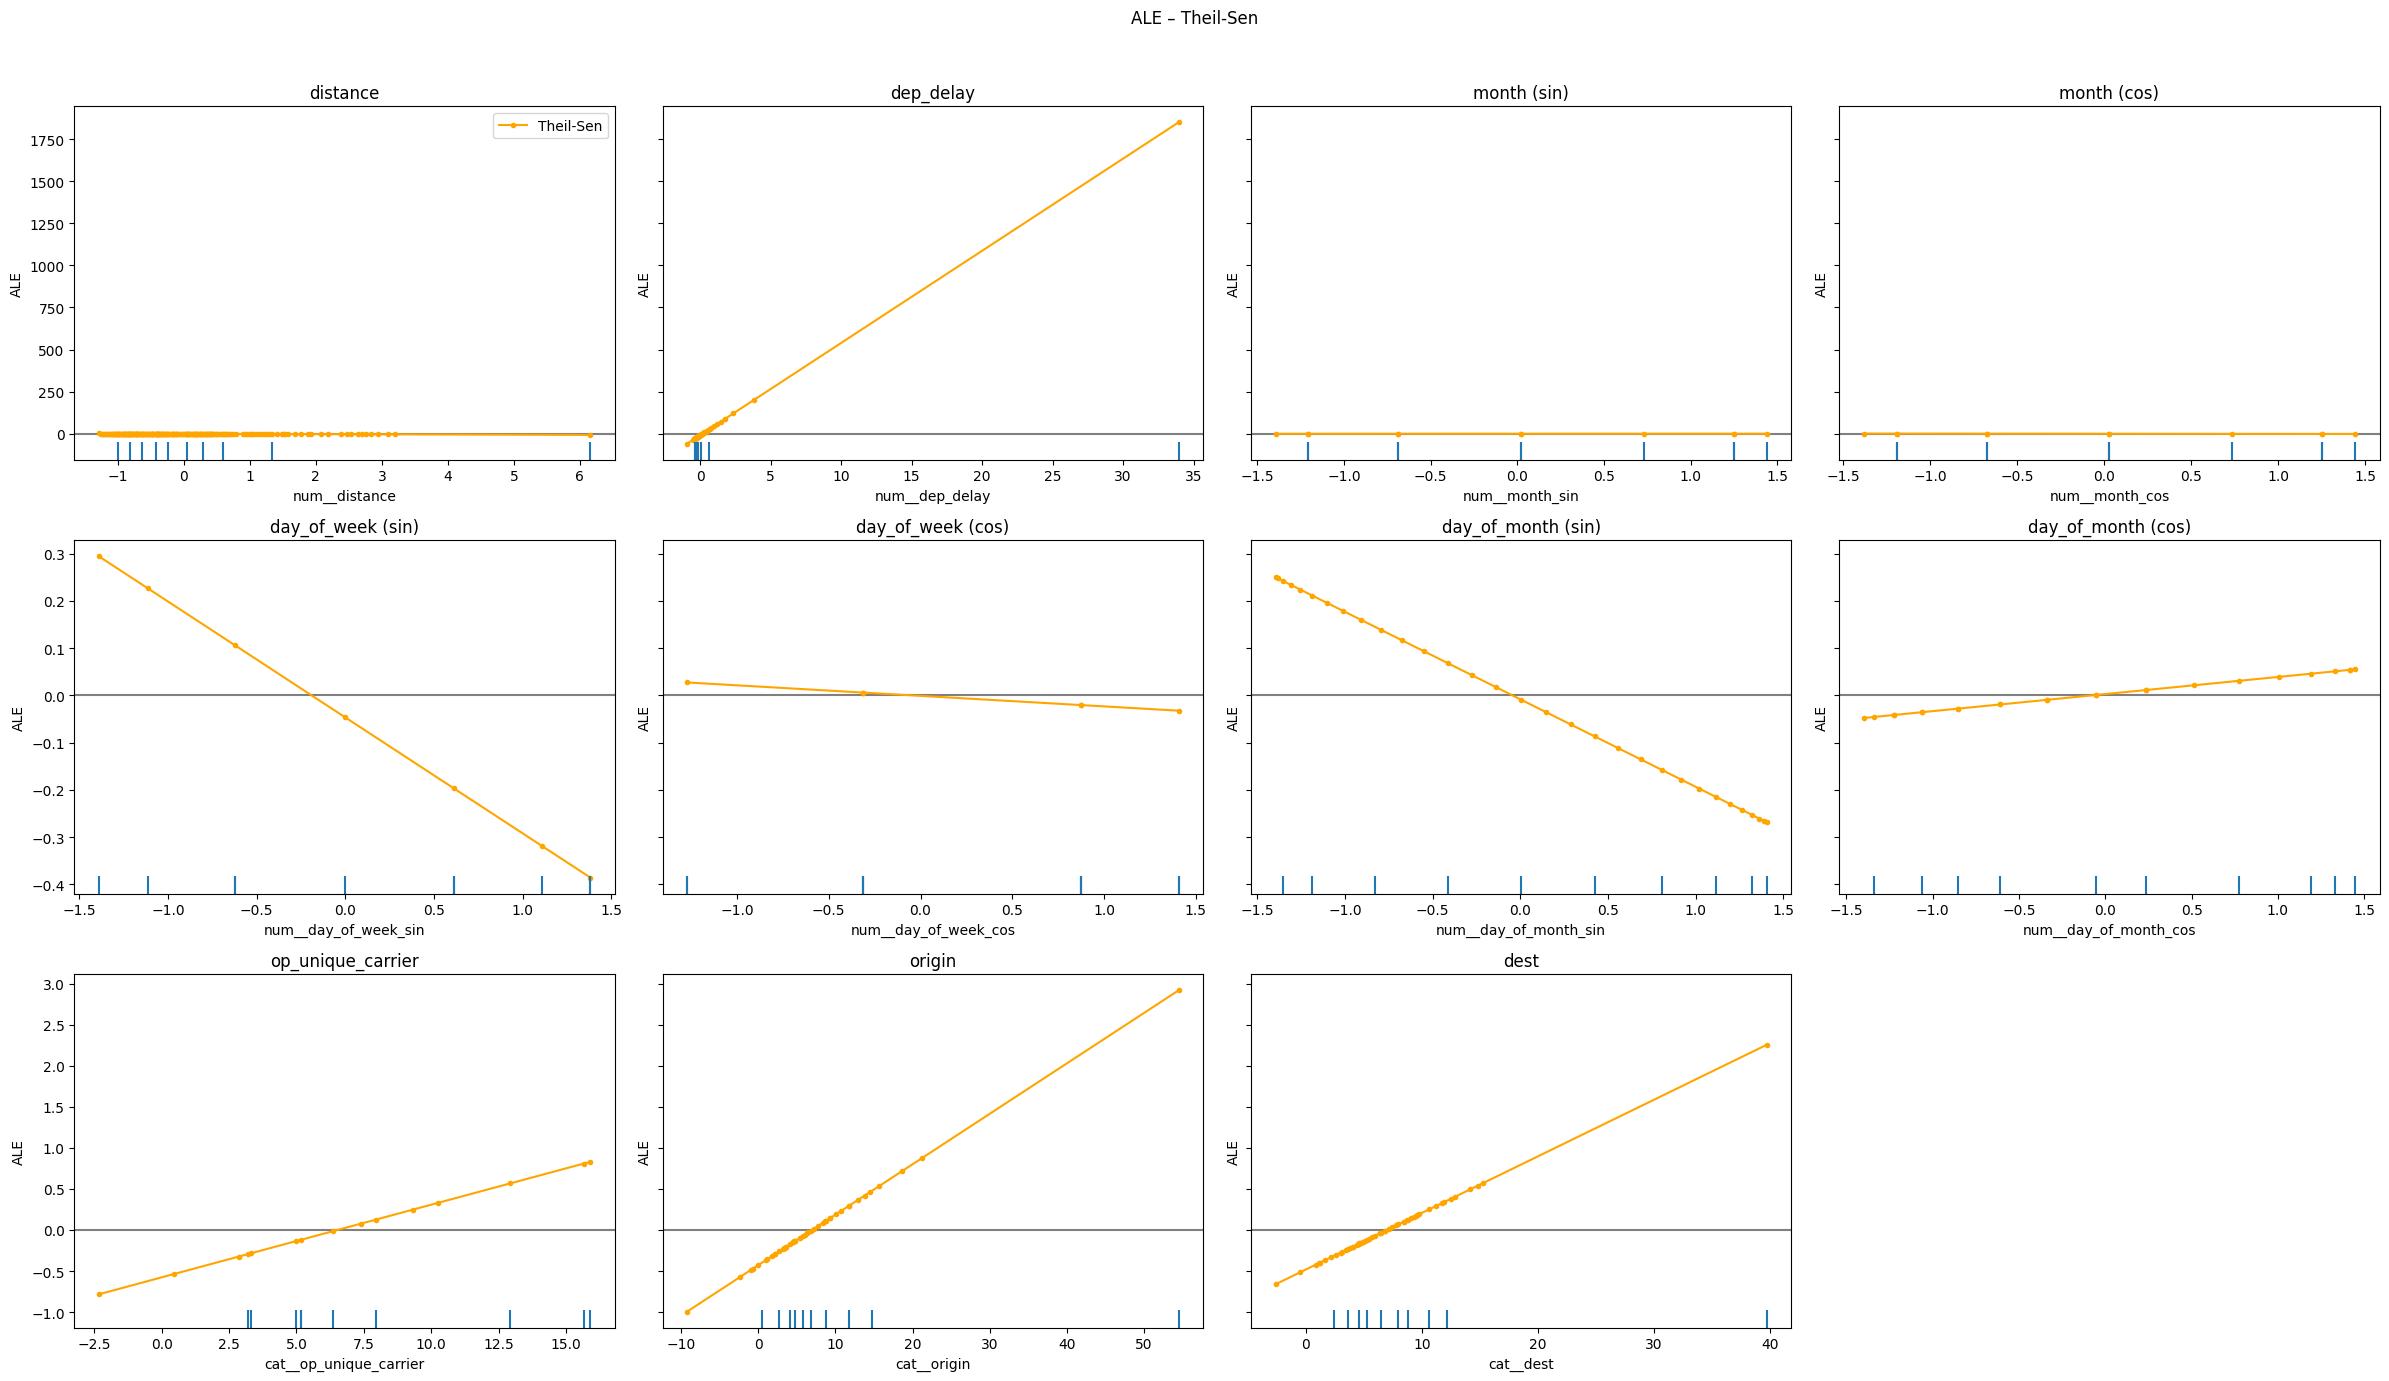

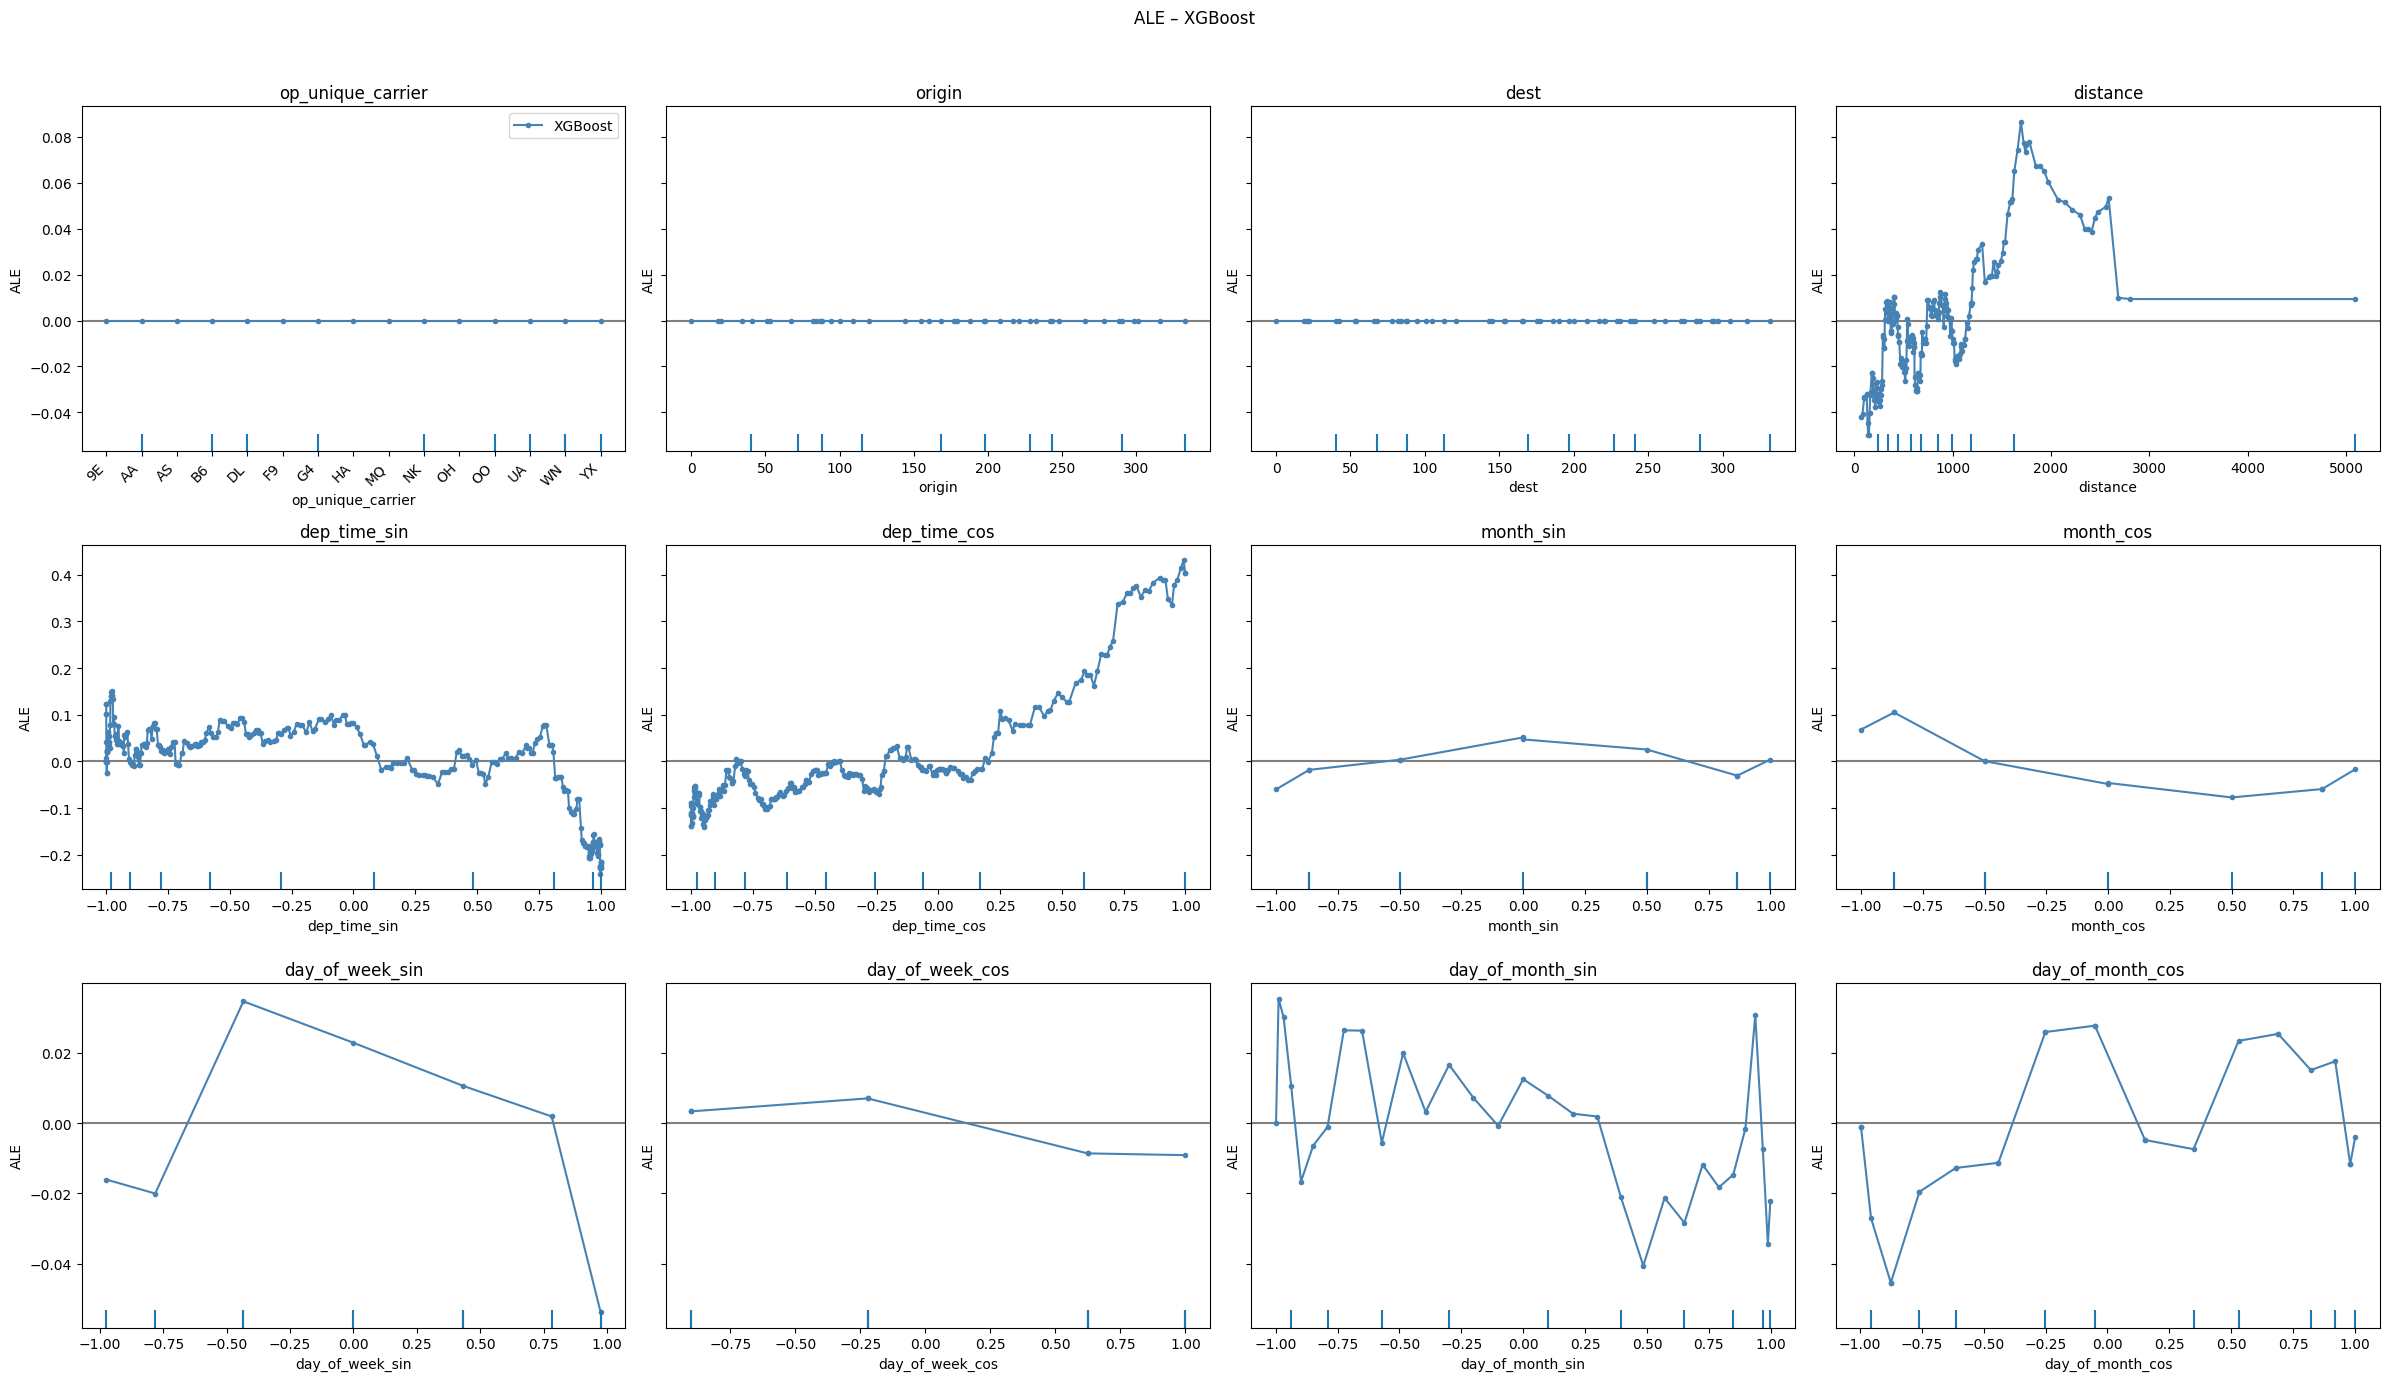

In [14]:
def plot_model_ale(exp_result, feature_names: List[str], title: str, color: str, cat_map: Dict[str, List[str]] = None):
    if exp_result is None or not feature_names:
        print(f"Skipping {title}: missing ALE results or feature names. Run the preprocessing cell and retry.")
        return

    max_features = min(12, len(feature_names)) # Increased to show more features
    features_to_plot = list(range(max_features))
    n_cols = min(4, max_features)
    n_rows = int(np.ceil(max_features / n_cols))
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(6 * n_cols, 4.5 * n_rows),
        sharey="row",
    )
    axes = np.atleast_2d(axes)

    # Use alibi's plot_ale
    plot_ale(
        exp_result,
        features=features_to_plot,
        ax=axes,
        line_kw={"label": title, "color": color},
    )

    # Customize plots
    for idx, feature_idx in enumerate(features_to_plot):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        feat_name = feature_names[feature_idx]
        ax.set_title(feat_name)

        # Handle Categorical Labels
        if cat_map and feat_name in cat_map:
            labels = cat_map[feat_name]
            # Alibi plots at integer codes 0, 1, 2...
            # We set ticks at these integers and label them
            # If too many categories, we might want to rotate or sample
            if len(labels) <= 20:
                ax.set_xticks(range(len(labels)))
                ax.set_xticklabels(labels, rotation=45, ha='right')
            else:
                # Too many categories, just show some or keep as is
                pass

    for extra_ax in axes.flat[max_features:]:
        extra_ax.set_visible(False)

    axes.flat[0].legend()
    fig.suptitle(f"ALE – {title}", y=1.02)
    plt.tight_layout()
    plt.show()


plot_model_ale(ts_exp, ts_readable_feature_names, "Theil-Sen", "orange")
# Pass the global category_map to the XGBoost plotter
plot_model_ale(xgb_exp, xgb_readable_feature_names, "XGBoost", "steelblue", cat_map=category_map)